In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
# Імпорти для порівняльної моделі:
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns 

# Встановлюємо зерно для відтворюваності
torch.manual_seed(42)
np.random.seed(42)

# Гіперпараметри (залишаються незмінними)
INPUT_SIZE = 11 # Кількість ознак
HIDDEN_SIZES = [64, 32] 
OUTPUT_SIZE = 6 # Класи якості вина (3-8, перетворені на 0-5)
LEARNING_RATE = 0.001
EPOCHS = 1000
BATCH_SIZE = 32

In [4]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# --- 1. Підготовка даних (ВИПРАВЛЕНО) ---

def load_and_preprocess_data(file_path='wineQT.csv'):
    """
    Завантажує, нормалізує дані, розділяє на тренувальну, валідаційну та тестову вибірки
    та конвертує їх у тензори PyTorch.
    """
    # 1. Завантажити CSV з даними про вино (використовуємо кому за замовчуванням)
    try:
        data = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Помилка: Файл {file_path} не знайдено.")
        return None, None, None, None, None, None

    # Видалення стовпця 'Id'
    if 'Id' in data.columns:
        print("Знайдено та видалено стовпець 'Id'.")
        data = data.drop('Id', axis=1)
        
    target_column = 'quality'
    
    if target_column not in data.columns:
        print(f"Помилка: Цільовий стовпець '{target_column}' не знайдено.")
        return None, None, None, None, None, None
        
    # Якість вина від 3 до 8. Перетворюємо на класи 0-5.
    data[target_column] = data[target_column] - 3

    # 2. Відокремити ознаки (X) та мітки (y)
    X = data.drop(target_column, axis=1).values
    y = data[target_column].values

    # 3. Нормалізувати ознаки
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 4. Розділити дані на тренувальну/валідаційну/тестову вибірки
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    # 5. Конвертувати в тензори PyTorch
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    return X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t

In [20]:
# --- 2. Функції активації (реалізація з нуля) ---

class ActivationFunctions:
    @staticmethod
    def relu(x, derivative=False):
        if derivative:
            return (x > 0).float()
        return torch.clamp(x, min=0)

    @staticmethod
    def tanh(x, derivative=False):
        if derivative:
            return 1 - torch.tanh(x).pow(2)
        return torch.tanh(x)

    @staticmethod
    def softmax(x):
        exp_x = torch.exp(x - torch.max(x, dim=0, keepdim=True).values)
        return exp_x / torch.sum(exp_x, dim=0, keepdim=True)

In [21]:
# --- 3. Функція втрат (реалізація з нуля) ---

class LossFunctions:
    @staticmethod
    def categorical_cross_entropy(y_pred_probs, y_true_indices, derivative=False):
        M = y_pred_probs.shape[1] 

        if derivative:
            # Оптимізована похідна для Softmax + Cross-Entropy
            grad = y_pred_probs.clone() 
            grad[y_true_indices, torch.arange(M)] -= 1
            return grad / M 

        correct_probs = y_pred_probs[y_true_indices, torch.arange(M)]
        correct_probs = torch.clamp(correct_probs, 1e-12, 1.0)
        loss = -torch.sum(torch.log(correct_probs)) / M
        return loss

In [22]:
# --- 4. Власна реалізація MLP ---

class CustomMLP:
    def __init__(self, layer_sizes, activations, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.activations = activations 
        self.learning_rate = learning_rate
        self.parameters = {}
        self.grads = {}
        self.initialize_parameters_xavier()

    def initialize_parameters_xavier(self):
        L = len(self.layer_sizes)
        for i in range(1, L):
            prev_size = self.layer_sizes[i-1]
            curr_size = self.layer_sizes[i]
            limit = np.sqrt(2. / (prev_size + curr_size))
            W = torch.randn(curr_size, prev_size) * limit
            b = torch.zeros(curr_size, 1)

            self.parameters[f'W{i}'] = W
            self.parameters[f'b{i}'] = b

    def forward(self, X):
        A_prev = X.T
        cache = {'A0': A_prev}
        L = len(self.layer_sizes) - 1 

        for i in range(1, L + 1):
            W = self.parameters[f'W{i}'] 
            b = self.parameters[f'b{i}'] 
            Z = W @ A_prev + b
            cache[f'Z{i}'] = Z 

            if i < L: 
                A = ActivationFunctions.tanh(Z)
                cache[f'A{i}'] = A
                A_prev = A
            else: 
                A = ActivationFunctions.softmax(Z)
                cache[f'A{i}'] = A
                A_prev = A

        return A_prev, cache 

    def backward(self, X, y, cache):
        M = X.shape[0] 
        L = len(self.layer_sizes) - 1 
        self.grads = {}

        # 1. Градієнт для вихідного шару L
        A_L = cache[f'A{L}'] 
        dZ_L = LossFunctions.categorical_cross_entropy(A_L, y, derivative=True)

        A_prev = cache[f'A{L-1}'] 
        self.grads[f'dW{L}'] = dZ_L @ A_prev.T
        self.grads[f'db{L}'] = torch.sum(dZ_L, dim=1, keepdim=True)

        # 2. Поширення назад через приховані шари
        dA_prev = dZ_L 

        for i in reversed(range(1, L)): 
            Z_curr = cache[f'Z{i}']
            A_prev = cache[f'A{i-1}'] 
            W_next = self.parameters[f'W{i+1}'] 

            # dA_curr = dL/dA_i = (dL/dZ_{i+1}) @ W_{i+1}^T
            dA_curr = W_next.T @ dA_prev

            # dZ_i = dL/dZ_i = (dL/dA_i) * (dA_i/dZ_i)
            dZ_curr = dA_curr * ActivationFunctions.tanh(Z_curr, derivative=True)
            dA_prev = dZ_curr 

            # Обчислення градієнтів W_i та b_i
            self.grads[f'dW{i}'] = dZ_curr @ A_prev.T
            self.grads[f'db{i}'] = torch.sum(dZ_curr, dim=1, keepdim=True)


    def update_parameters(self):
        L = len(self.layer_sizes) - 1
        for i in range(1, L + 1):
            self.parameters[f'W{i}'] -= self.learning_rate * self.grads[f'dW{i}']
            self.parameters[f'b{i}'] -= self.learning_rate * self.grads[f'db{i}']


    def train(self, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        N_train = X_train.shape[0]
        num_batches = N_train // batch_size

        for epoch in range(1, epochs + 1):
            permutation = torch.randperm(N_train)
            X_shuffled = X_train[permutation]
            y_shuffled = y_train[permutation]
            epoch_train_loss = 0.0

            for j in range(num_batches):
                start_idx = j * batch_size
                end_idx = start_idx + batch_size

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                y_pred_probs, cache = self.forward(X_batch)
                loss = LossFunctions.categorical_cross_entropy(y_pred_probs, y_batch)
                epoch_train_loss += loss.item()
                self.backward(X_batch, y_batch, cache)
                self.update_parameters()

            avg_train_loss = epoch_train_loss / num_batches
            train_acc = self.evaluate(X_train, y_train)
            val_loss, val_acc = self.validate(X_val, y_val)

            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs} | Custom MLP: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return history

    def predict(self, X):
        y_pred_probs, _ = self.forward(X)
        return torch.argmax(y_pred_probs.T, dim=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X).numpy()
        y_true = y.numpy()
        return accuracy_score(y_true, y_pred)

    def validate(self, X_val, y_val):
        y_pred_probs, _ = self.forward(X_val)
        val_loss = LossFunctions.categorical_cross_entropy(y_pred_probs, y_val).item()
        val_acc = self.evaluate(X_val, y_val)
        return val_loss, val_acc

In [23]:
# --- 5. PyTorch реалізація для порівняння ---

class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(PyTorchMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.Tanh(), 
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.Tanh(),
            nn.Linear(hidden_sizes[1], output_size)
        )
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        self.apply(init_weights)

    def forward(self, x):
        return self.layers(x)

def train_pytorch_model(model, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.01, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    N_train = X_train.shape[0]
    num_batches = N_train // batch_size

    for epoch in range(1, epochs + 1):
        model.train()
        permutation = torch.randperm(N_train)
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]
        epoch_train_loss = 0.0

        for j in range(num_batches):
            start_idx = j * batch_size
            end_idx = start_idx + batch_size

            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward() 
            optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        avg_train_loss = epoch_train_loss / num_batches

        with torch.no_grad():
            train_preds = model(X_train).argmax(dim=1)
            train_acc = accuracy_score(y_train.numpy(), train_preds.numpy())
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_preds = val_outputs.argmax(dim=1)
            val_acc = accuracy_score(y_val.numpy(), val_preds.numpy())

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | PyTorch MLP: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

--- 1. Підготовка даних ---
Знайдено та видалено стовпець 'Id'.
Розміри: X_train=torch.Size([685, 11]), X_val=torch.Size([229, 11]), X_test=torch.Size([229, 11])
------------------------------
--- 4. Навчання CustomMLP (з нуля) ---
Epoch 100/1000 | Custom MLP: Train Loss: 1.0657, Val Loss: 1.0408, Val Acc: 0.5852
Epoch 200/1000 | Custom MLP: Train Loss: 0.9625, Val Loss: 0.9449, Val Acc: 0.6070
Epoch 300/1000 | Custom MLP: Train Loss: 0.9150, Val Loss: 0.9283, Val Acc: 0.6026
Epoch 400/1000 | Custom MLP: Train Loss: 0.9058, Val Loss: 0.9248, Val Acc: 0.6114
Epoch 500/1000 | Custom MLP: Train Loss: 0.9061, Val Loss: 0.9241, Val Acc: 0.6157
Epoch 600/1000 | Custom MLP: Train Loss: 0.8882, Val Loss: 0.9249, Val Acc: 0.6114
Epoch 700/1000 | Custom MLP: Train Loss: 0.8832, Val Loss: 0.9255, Val Acc: 0.6157
Epoch 800/1000 | Custom MLP: Train Loss: 0.8825, Val Loss: 0.9263, Val Acc: 0.6114
Epoch 900/1000 | Custom MLP: Train Loss: 0.8640, Val Loss: 0.9274, Val Acc: 0.6026
Epoch 1000/1000 | Cus

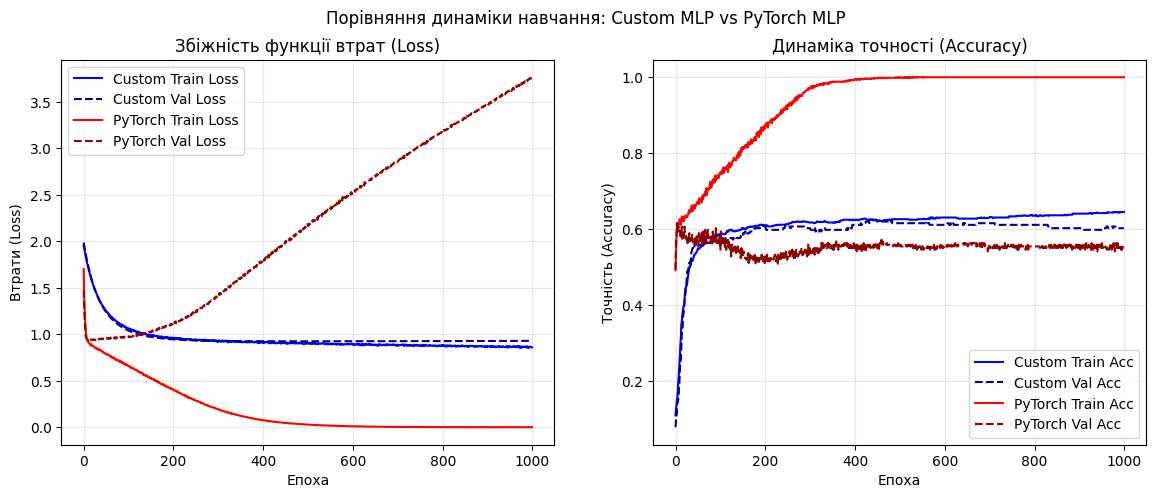

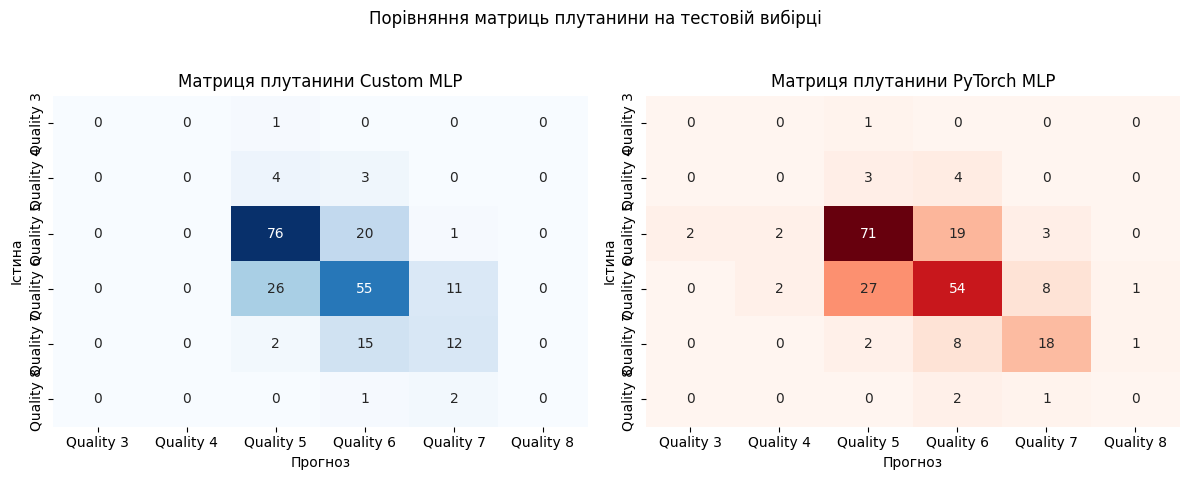

In [24]:
# --- 6. Візуалізація та аналіз ---

def plot_training_history(history_custom, history_pytorch):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Графік втрат
    axes[0].plot(history_custom['train_loss'], label='Custom Train Loss', color='blue')
    axes[0].plot(history_custom['val_loss'], label='Custom Val Loss', color='darkblue', linestyle='--')
    axes[0].plot(history_pytorch['train_loss'], label='PyTorch Train Loss', color='red')
    axes[0].plot(history_pytorch['val_loss'], label='PyTorch Val Loss', color='darkred', linestyle='--')
    axes[0].set_title('Збіжність функції втрат (Loss)')
    axes[0].set_xlabel('Епоха')
    axes[0].set_ylabel('Втрати (Loss)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Графік точності
    axes[1].plot(history_custom['train_acc'], label='Custom Train Acc', color='blue')
    axes[1].plot(history_custom['val_acc'], label='Custom Val Acc', color='darkblue', linestyle='--')
    axes[1].plot(history_pytorch['train_acc'], label='PyTorch Train Acc', color='red')
    axes[1].plot(history_pytorch['val_acc'], label='PyTorch Val Acc', color='darkred', linestyle='--')
    axes[1].set_title('Динаміка точності (Accuracy)')
    axes[1].set_xlabel('Епоха')
    axes[1].set_ylabel('Точність (Accuracy)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle('Порівняння динаміки навчання: Custom MLP vs PyTorch MLP')
    plt.show()

def plot_confusion_matrix(y_true, y_pred_custom, y_pred_pytorch, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Матриця плутанини Custom MLP
    cm_custom = confusion_matrix(y_true, y_pred_custom)
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Матриця плутанини Custom MLP')
    axes[0].set_xlabel('Прогноз')
    axes[0].set_ylabel('Істина')

    # Матриця плутанини PyTorch MLP
    cm_pytorch = confusion_matrix(y_true, y_pred_pytorch)
    sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Матриця плутанини PyTorch MLP')
    axes[1].set_xlabel('Прогноз')
    axes[1].set_ylabel('Істина')

    plt.suptitle('Порівняння матриць плутанини на тестовій вибірці')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Основний сценарій виконання ---

def main():
    print("--- 1. Підготовка даних ---")
    data_tuple = load_and_preprocess_data(file_path='wineQT.csv')

    if data_tuple is None or data_tuple[0] is None:
        print("Неможливо продовжити виконання через відсутність або пошкодження файлу даних.")
        return 

    X_train, y_train, X_val, y_val, X_test, y_test = data_tuple
    class_names = [f'Quality {i+3}' for i in range(OUTPUT_SIZE)]
    print(f"Розміри: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
    print("-" * 30)

    # Ініціалізація моделей
    layer_sizes = [INPUT_SIZE] + HIDDEN_SIZES + [OUTPUT_SIZE]

    # Custom MLP (реалізація з нуля)
    custom_model = CustomMLP(
        layer_sizes=layer_sizes,
        activations=[ActivationFunctions.tanh] * len(HIDDEN_SIZES),
        learning_rate=LEARNING_RATE
    )
    print("--- 4. Навчання CustomMLP (з нуля) ---")
    history_custom = custom_model.train(
        X_train, y_train, X_val, y_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    print("-" * 30)

    # PyTorch MLP (для порівняння)
    pytorch_model = PyTorchMLP(
        INPUT_SIZE,
        HIDDEN_SIZES,
        OUTPUT_SIZE
    )
    print("--- 5. Навчання PyTorchMLP (еталон) ---")
    history_pytorch = train_pytorch_model(
        pytorch_model,
        X_train, y_train, X_val, y_val,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        batch_size=BATCH_SIZE
    )
    print("-" * 30)

    # Оцінка на тестовій вибірці
    y_pred_custom = custom_model.predict(X_test).numpy()
    y_pred_pytorch = pytorch_model(X_test).argmax(dim=1).numpy()
    y_true_test = y_test.numpy()

    acc_custom = accuracy_score(y_true_test, y_pred_custom)
    acc_pytorch = accuracy_score(y_true_test, y_pred_pytorch)

    print("--- 6. Результати та аналіз ---")
    print(f"Точність Custom MLP на тестовій вибірці: {acc_custom:.4f}")
    print(f"Точність PyTorch MLP на тестовій вибірці: {acc_pytorch:.4f}")
    print("-" * 30)

    # Візуалізація історії навчання
    plot_training_history(history_custom, history_pytorch)

    # Візуалізація матриць плутанини
    plot_confusion_matrix(y_true_test, y_pred_custom, y_pred_pytorch, class_names)

if __name__ == '__main__':
    main()